In [5]:
import os
import mne
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from scipy.stats import linregress
from mne.time_frequency import psd_array_multitaper

from settings import paths
from helper_functions import save_figure

In [6]:
freq_bands = {
    r'$\delta$': (1, 4),  # Delta
    r'$\theta$': (4, 8),  # Theta
    r'$\alpha$': (8, 13),  # Alpha
    r'$\beta$': (13, 30),  # Beta
    r'$\gamma$': (30, 100)  # Gamma
}

Let's load the epochs of one subject for testing purposes and drop the channels we are not interested in.

In [11]:
epochs_dir = os.path.join(paths["epochs_folder"])

epochs = mne.read_epochs(os.path.join(epochs_dir, "filtered_epochs_w_movement_39508-epo.fif"), preload=True)

# let us drop the channels we are not interested in
epochs.drop_channels(['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

Reading C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\resting_state\output\epochs\ploss_thresh_500\filtered_epochs_w_movement_39508-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4998.53 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
3208 matching events found
No baseline correction applied
0 projection items activated


Number of events,3208
Events,1: 3208
Time range,0.000 – 4.999 s
Baseline,off


Define a dictionary with manually annotations of the 'good quality' EMG channels per subject.

In [13]:
quality_emgs = {
    81217: ["EMG_L"],
    81175: ["EMG_L", "EMG_R"],
    79592: ["EMG_R"],
    79593: ["EMG_L"],
    81207: ["EMG_R"],
    80625: ["EMG_R"],
    80630: ["EMG_L", "EMG_R"],
    78211: ["EMG_R"],
    39489: ["EMG_L"],
    80620: ["EMG_L", "EMG_R"],
    78227: ["EMG_L", "EMG_R"],
    78233: ["EMG_R"],
    39508: ["EMG_L", "EMG_R"],
    79604: ["EMG_L", "EMG_R"],
    81218: ["EMG_L", "EMG_R"],
    79602: ["EMG_L"],
    78244: ["EMG_L", "EMG_R"],
    81193: ["EMG_L", "EMG_R"],
}

## Epoch cleaning

In order to perform PCA and clustering, the data needs to be as clean as possible, which means we need to clean our epochs.

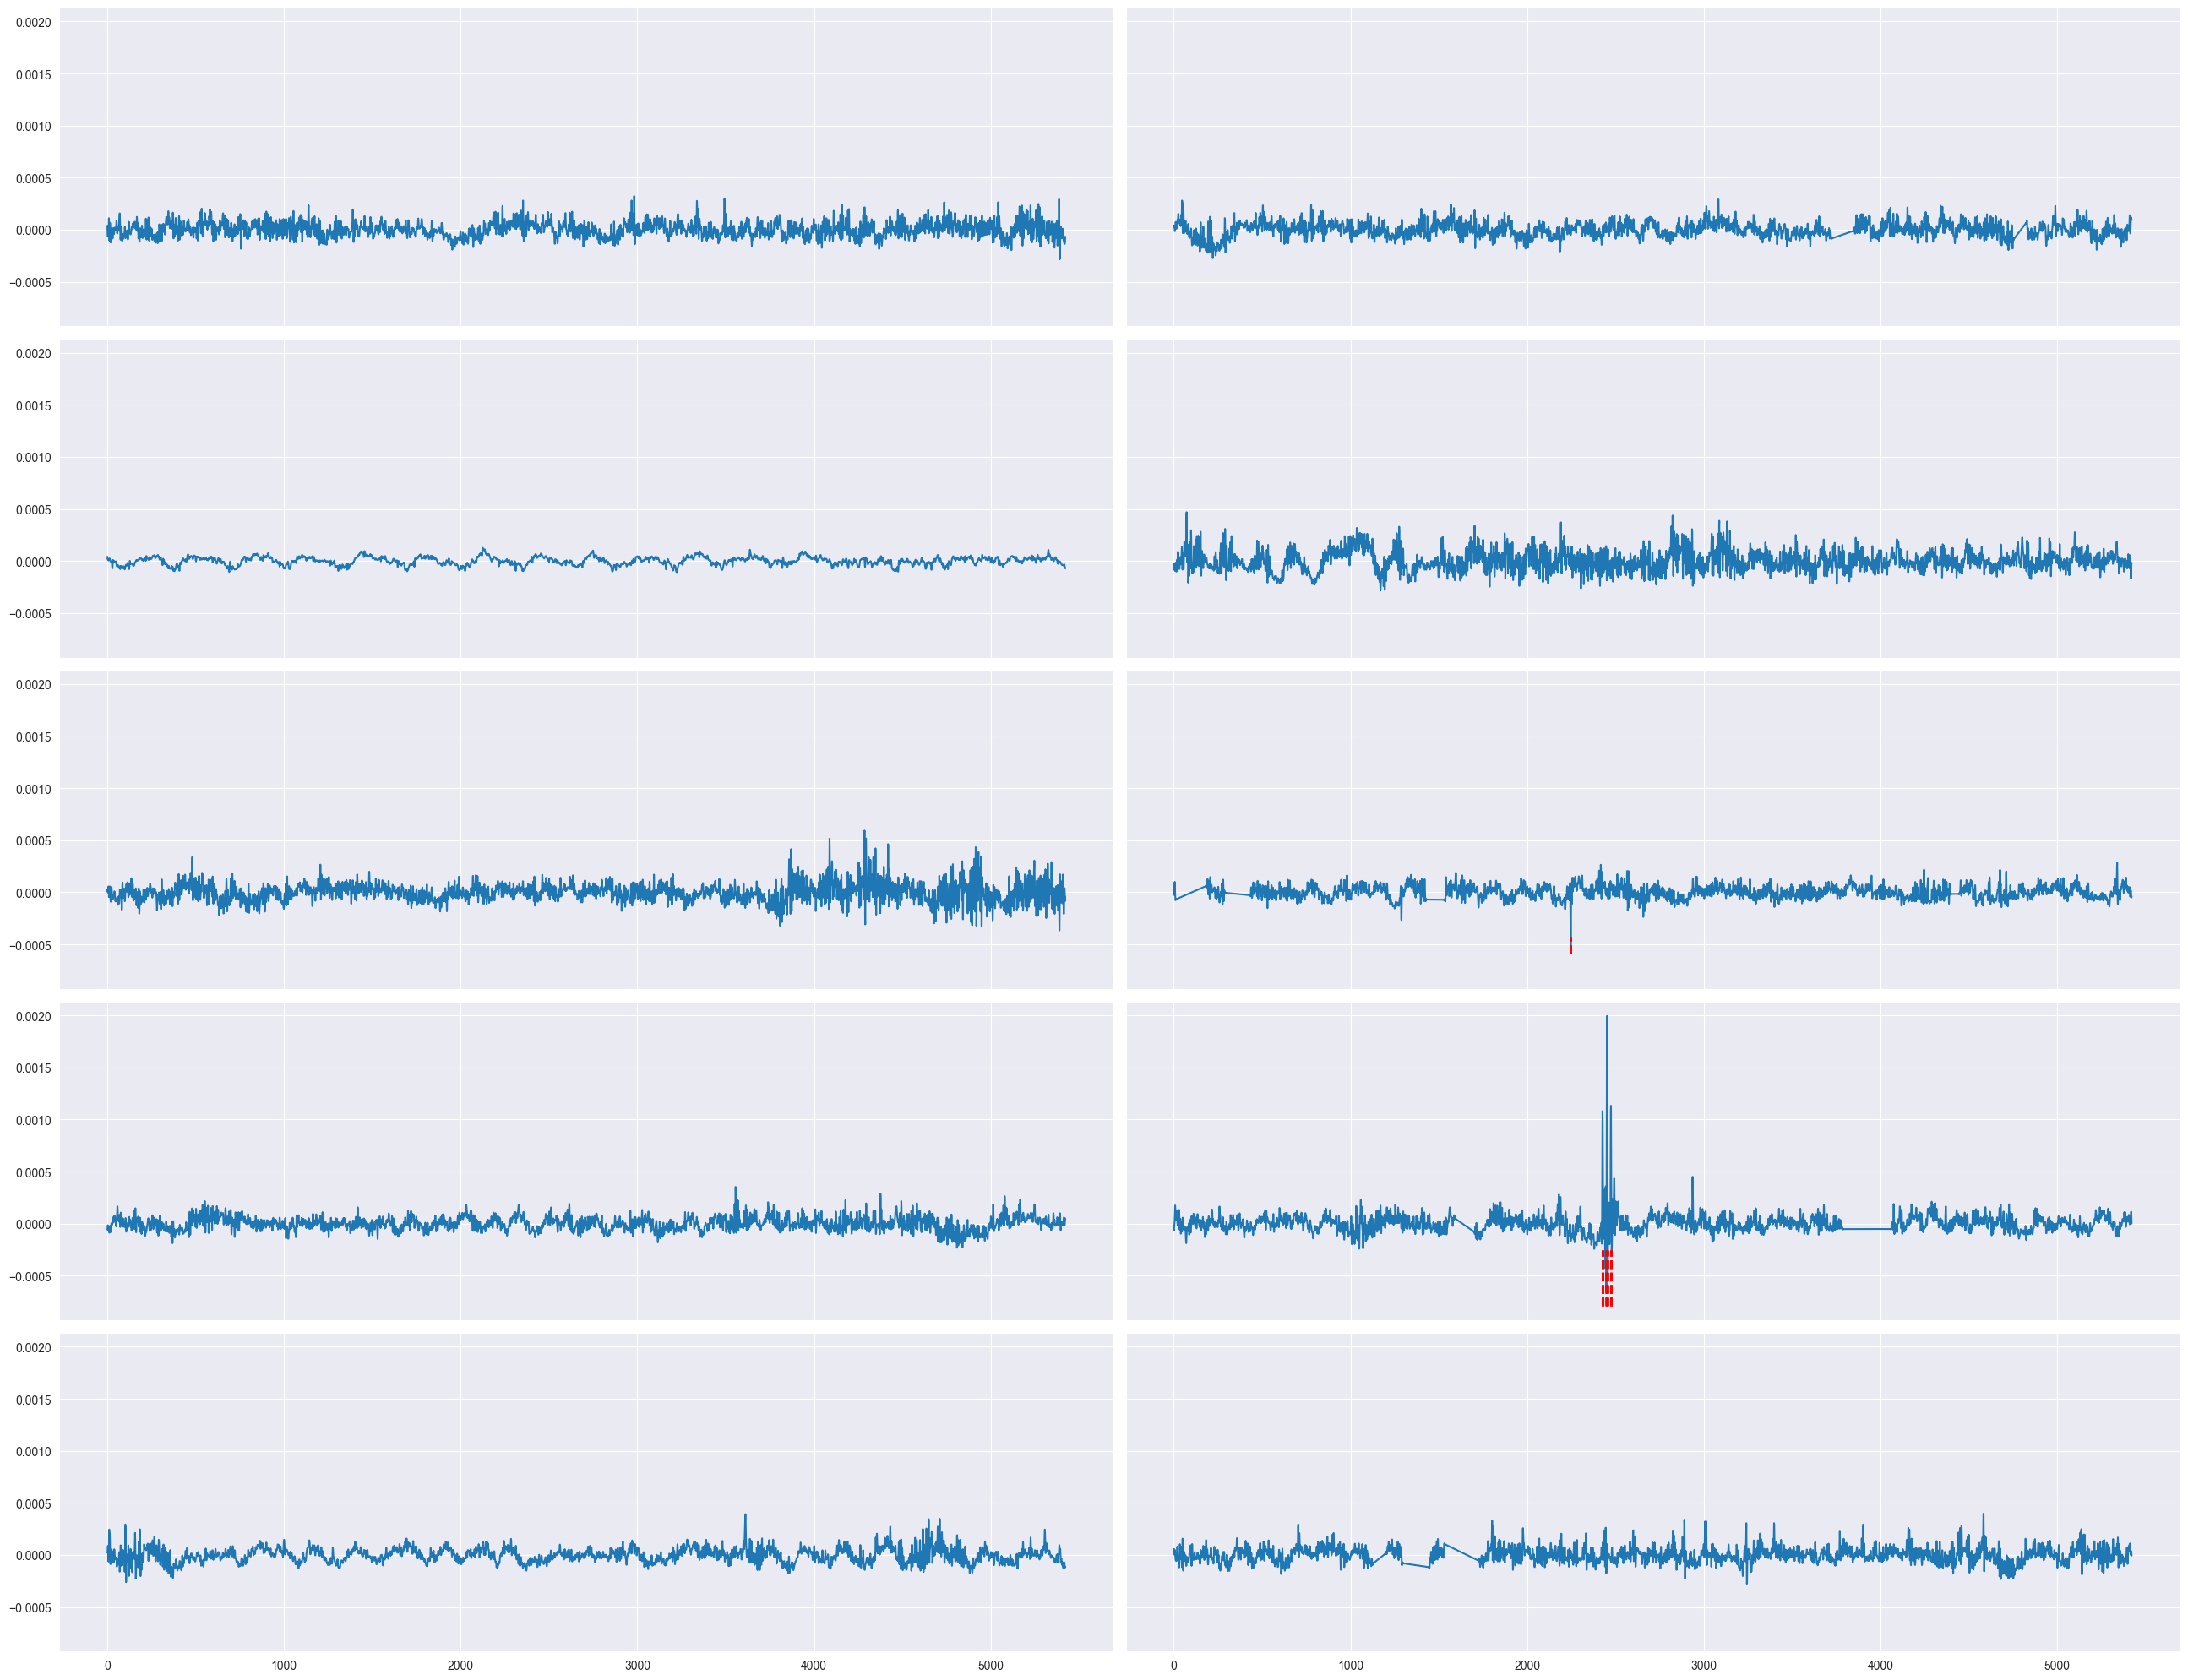

In [188]:
# random_epoch_indexes = random.sample(range(0, len(epochs)), 10)
random_epoch_indexes = [1036, 2046, 3152, 2269, 2357, 888, 2284, 2317, 2190, 2540]

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(26, 4 * 5), sharex=True, sharey=True)
axs = axs.ravel()

for i, random_epoch in enumerate(random_epoch_indexes):
    individual_epoch = epochs[random_epoch]
    individual_epoch = individual_epoch.get_data("EMG_L")[0,0,:]
    
    epoch_mean = np.mean(individual_epoch)
    epoch_std = np.std(individual_epoch)
    
    z_score_threshold = 7
    
    z_scores = (individual_epoch - epoch_mean) / epoch_std
    is_outlier = np.abs(z_scores) > z_score_threshold
    
    axs[i].plot(individual_epoch)
    ylim = axs[i].get_ylim()
    ymax = ylim[0] + ylim[1] / 4
    
    for j, flag in enumerate(is_outlier):
        if flag:
            axs[i].vlines(x=j, ymin=ylim[0], ymax=ymax, color='r', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

## Feature exploration

In [198]:
epoch_3152 = epochs[3152]
epoch_data_3152 = epoch_3152.get_data()
epoch_3152.metadata

C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1188\1286143265.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data_3152 = epoch_3152.get_data()


,animal_id,genotype,epochs_start_end_samples,epochs_start_end_frames,movement
3152,39508,DRD2-WT,20938203-20943626,578730.4916076848-578880.3436720549,False


In [199]:
epoch_1036 = epochs[1036]
epoch_data_1036 = epoch_1036.get_data()
epoch_1036.metadata

C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1188\2542448569.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data_1036 = epoch_1036.get_data()


,animal_id,genotype,epochs_start_end_samples,epochs_start_end_frames,movement
1036,39508,DRD2-WT,7212590-7218013,199454.91668668343-199604.76875105363,True


### Movement vs. non-movement epoch (likely a sleep one)

Let's get a good overview of a non-movement (likely sleep), and a movement epoch.

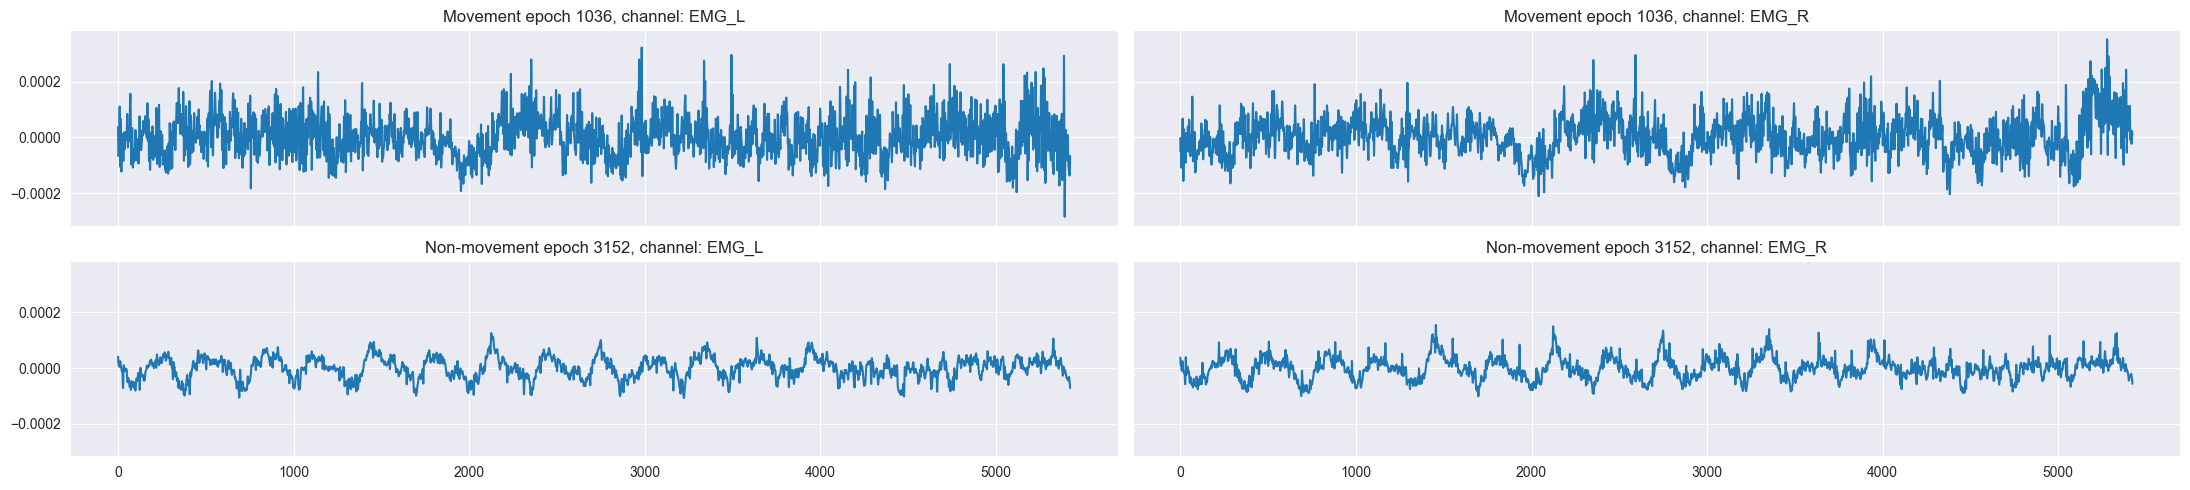

In [258]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(22, 5), sharex=True, sharey=True)
axs = axs.ravel()
axs[0].plot(epoch_data_1036[0,0,:])
axs[0].set_title("Movement epoch 1036, channel: EMG_L")
axs[1].plot(epoch_data_1036[0,1,:])
axs[1].set_title("Movement epoch 1036, channel: EMG_R")
axs[2].plot(epoch_data_3152[0,0,:])
axs[2].set_title("Non-movement epoch 3152, channel: EMG_L")
axs[3].plot(epoch_data_3152[0,1,:])
axs[3].set_title("Non-movement epoch 3152, channel: EMG_R")

plt.tight_layout()
plt.show()

### Two different kinds of non-movement epochs

There seem to be two types of non-movement EMG epochs, clearly separable by eye. Let's plot an example of those two in the same manner.

In [259]:
epoch_1098 = epochs[1098]
epoch_data_1098 = epoch_1098.get_data()
epoch_1098.metadata

C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1188\3212742817.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data_1098 = epoch_1098.get_data()


,animal_id,genotype,epochs_start_end_samples,epochs_start_end_frames,movement
1098,39508,DRD2-WT,7662699-7668122,211892.63802941085-212042.49009378106,False


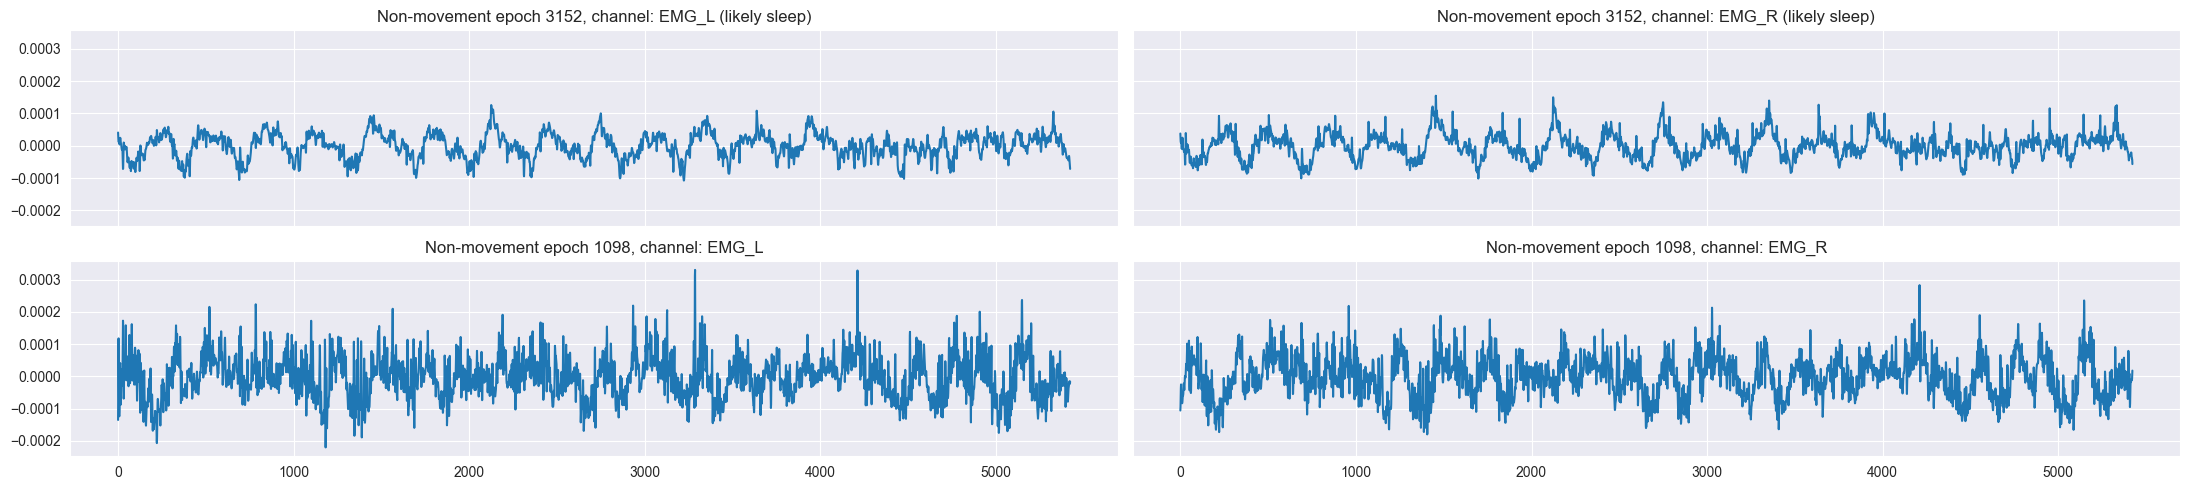

In [260]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(22, 5), sharex=True, sharey=True)
axs = axs.ravel()
axs[0].plot(epoch_data_3152[0,0,:])
axs[0].set_title("Non-movement epoch 3152, channel: EMG_L (likely sleep)")
axs[1].plot(epoch_data_3152[0,1,:])
axs[1].set_title("Non-movement epoch 3152, channel: EMG_R (likely sleep)")
axs[2].plot(epoch_data_1098[0,0,:])
axs[2].set_title("Non-movement epoch 1098, channel: EMG_L")
axs[3].plot(epoch_data_1098[0,1,:])
axs[3].set_title("Non-movement epoch 1098, channel: EMG_R")
plt.tight_layout()
plt.show()

It is evident that there's a big difference between the slow-wave, non-gamma wave epoch and the movement one. But the non-movement epoch that does have gamma waves is more similar to the movement one. This makes it hard to distinguish the two. 

Now, we will try different measures to separate the two.

First, let's try something that has to do with the amplitude.

In [296]:
df_test_features = pd.DataFrame()
for i, (epoch_type, signal) in enumerate({"Non-mov (slow wave)": epoch_data_3152, "Non-mov (other)": epoch_data_1098, "Movement": epoch_data_1036}.items()):
    signal_l = signal[0,0,:]
    
    peak_to_peak_amplitude = np.max(signal_l) - np.min(signal_l)
    rms_amplitude = np.sqrt(np.mean(signal_l**2))
    peak_amplitude = np.max(np.abs(signal_l))
    zero_crossings = np.where(np.diff(np.sign(signal_l)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal_l)
    # envelope
    analytic_signal = hilbert(signal_l)
    envelope_amplitude = np.abs(analytic_signal)
    mean_envelope_amplitude = np.mean(envelope_amplitude)
    # envelope auc
    masked_series = np.where(envelope_amplitude > 0, envelope_amplitude, 0)
    envelope_amplitude_auc = np.trapz(masked_series)
    
    df_test_features = pd.concat([df_test_features, pd.DataFrame({
        "Epoch type": epoch_type,
        "Peak-to-Peak Amplitude": peak_to_peak_amplitude,
        "RMS Amplitude": rms_amplitude,
        "Peak Amplitude": peak_amplitude,
        "Zero Crossing Rate": zero_crossing_rate,
        "Envelope Amplitude": mean_envelope_amplitude,
        "Envelope AUC": envelope_amplitude_auc
    }, index=[i])])
df_test_features

,Epoch type,Peak-to-Peak Amplitude,RMS Amplitude,Peak Amplitude,Zero Crossing Rate,Envelope Amplitude,Envelope AUC
0,Non-mov (slow wave),0.000234,0.000038,0.000126,0.048128,0.000048,0.261953
1,Non-mov (other),0.000550,0.000064,0.000330,0.119491,0.000079,0.426281
2,Movement,0.000608,0.000069,0.000323,0.156187,0.000085,0.463170


It seems that most of these features, but especially the zero-crossing-rate and the envelope AUC are very promising. We will now have to see how they perform when clustering all non-movement epochs.

## Feature engineering

Define some functions that help us generate EMG features

In [329]:
def calculate_psd_features(signal, channel_name, sfreq):
    psds = {}
    for band, (start, end) in freq_bands.items():
        psd, freq = psd_array_multitaper(signal, fmin=start, fmax=end, sfreq=sfreq, n_jobs=-1, verbose=False)
        psds[f"{channel_name}_{band}"] = np.mean(np.log(psd))
    return psds


def extract_features(subject_epochs, subject_id):
    subject_epochs = subject_epochs[:-1]
    sfreq = subject_epochs.info['sfreq']
    all_features = []
    channel_names = quality_emgs[int(subject_id)]
    
    # loop through the epochs in the subject's epochs
    for i, epoch in enumerate(subject_epochs):
        
        # features per epoch are stored in here
        features = {}
        
        # loop through each quality EMG channel for this subject and store that channels features
        # in this looped epoch dictionary
        for j, channel_name in enumerate(channel_names):
            
            channel_data = epoch[j, :]  # get the right channel data
            
            # zero-crossings
            zero_crossings = np.where(np.diff(np.sign(channel_data)))[0]
            # envelope
            analytic_signal = hilbert(channel_data)
            envelope_amplitude = np.abs(analytic_signal)
            mean_envelope_amplitude = np.mean(envelope_amplitude)
            # envelope auc
            masked_series = np.where(envelope_amplitude > 0, envelope_amplitude, 0)
            envelope_amplitude_auc = np.trapz(masked_series)
            
            features.update({
                'subject_id': subject_id,
                'epoch_n': i,
                'movement': epochs.metadata["movement"].iloc[i],
                'frame_start_end': epochs.metadata["epochs_start_end_frames"].iloc[i],
                f"{channel_name} Peak-to-Peak Amplitude": np.max(channel_data) - np.min(channel_data),
                f"{channel_name} RMS Amplitude": np.sqrt(np.mean(channel_data**2)),
                f"{channel_name} Peak Amplitude": np.max(np.abs(channel_data)),
                f"{channel_name} Zero Crossing Rate": len(zero_crossings) / len(channel_data),
                f"{channel_name} Envelope Amplitude": mean_envelope_amplitude,
                f"{channel_name} Envelope AUC": envelope_amplitude_auc
            })
            features.update(calculate_psd_features(channel_data, channel_name, sfreq))
        
        # store this epoch's features in the list
        all_features.append(features)
        
    # return list holding dict with all features per epoch
    return all_features

Generate the dictionary holding the features per channel for all epochs

In [330]:
all_features = extract_features(epochs, epochs.metadata["animal_id"].iloc[0])
df_full = pd.DataFrame(all_features)
df_full.head(75)

,subject_id,epoch_n,movement,frame_start_end,EMG_L Peak-to-Peak Amplitude,EMG_L RMS Amplitude,EMG_L Peak Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,...,EMG_R RMS Amplitude,EMG_R Peak Amplitude,EMG_R Zero Crossing Rate,EMG_R Envelope Amplitude,EMG_R Envelope AUC,EMG_R_$\delta$,EMG_R_$\theta$,EMG_R_$\alpha$,EMG_R_$\beta$,EMG_R_$\gamma$
0,39508,0,True,151.6710743042171-301.52313867442706,0.000710,0.000098,0.000478,0.125576,0.000116,0.631252,...,0.000096,0.000465,0.108058,0.000110,0.594343,-14.984551,-16.523346,-16.540829,-17.798912,-18.425358
1,39508,1,True,751.0793317850569-900.9313961552668,0.002071,0.000066,0.001715,0.135903,0.000071,0.385548,...,0.000062,0.000292,0.124839,0.000077,0.417756,-14.826422,-16.116654,-16.821486,-18.045887,-18.620344
2,39508,2,True,900.9313961552668-1050.7834605254768,0.001905,0.000090,0.001485,0.122257,0.000096,0.520455,...,0.000094,0.001309,0.075051,0.000102,0.555198,-13.793255,-15.219617,-16.139220,-17.866521,-18.191740
3,39508,3,True,1200.6355248956868-1350.4875892658965,0.002234,0.000107,0.001575,0.126314,0.000103,0.559976,...,0.000086,0.001290,0.093491,0.000085,0.461157,-14.193981,-15.459761,-16.311571,-17.762512,-17.718144
4,39508,4,True,1500.3396536361067-1650.1917180063165,0.000505,0.000064,0.000311,0.137193,0.000078,0.423843,...,0.000061,0.000278,0.131293,0.000076,0.410830,-15.275300,-16.487884,-16.286096,-17.722915,-18.385399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,39508,70,True,13938.06099636353-14087.913060733741,0.000460,0.000063,0.000271,0.082058,0.000078,0.423396,...,0.000062,0.000283,0.069519,0.000078,0.422683,-14.868636,-15.230328,-16.932604,-18.287569,-18.847610
71,39508,71,False,14087.913060733741-14237.765125103952,0.000781,0.000073,0.000521,0.123917,0.000091,0.492476,...,0.000069,0.000485,0.112115,0.000085,0.462528,-15.229335,-16.532472,-16.095687,-17.769207,-18.400488
72,39508,72,False,14237.765125103952-14387.61718947416,0.000740,0.000074,0.000434,0.132768,0.000089,0.483936,...,0.000066,0.000338,0.117094,0.000082,0.446587,-14.620380,-15.790112,-16.971779,-17.945769,-18.587934
73,39508,73,False,14387.61718947416-14537.46925384437,0.000456,0.000062,0.000300,0.069519,0.000080,0.432900,...,0.000061,0.000274,0.072838,0.000078,0.424927,-15.430927,-14.733272,-17.527609,-18.336216,-19.097416


Seems like this df is correct. Let's transform the movement column, and then also create a df holding only the data we want to cluster on and perform PCA on.

In [332]:
df_full["movement"] = df_full["movement"].astype(int)
df_full.head(75)

,subject_id,epoch_n,movement,frame_start_end,EMG_L Peak-to-Peak Amplitude,EMG_L RMS Amplitude,EMG_L Peak Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,...,EMG_R RMS Amplitude,EMG_R Peak Amplitude,EMG_R Zero Crossing Rate,EMG_R Envelope Amplitude,EMG_R Envelope AUC,EMG_R_$\delta$,EMG_R_$\theta$,EMG_R_$\alpha$,EMG_R_$\beta$,EMG_R_$\gamma$
0,39508,0,1,151.6710743042171-301.52313867442706,0.000710,0.000098,0.000478,0.125576,0.000116,0.631252,...,0.000096,0.000465,0.108058,0.000110,0.594343,-14.984551,-16.523346,-16.540829,-17.798912,-18.425358
1,39508,1,1,751.0793317850569-900.9313961552668,0.002071,0.000066,0.001715,0.135903,0.000071,0.385548,...,0.000062,0.000292,0.124839,0.000077,0.417756,-14.826422,-16.116654,-16.821486,-18.045887,-18.620344
2,39508,2,1,900.9313961552668-1050.7834605254768,0.001905,0.000090,0.001485,0.122257,0.000096,0.520455,...,0.000094,0.001309,0.075051,0.000102,0.555198,-13.793255,-15.219617,-16.139220,-17.866521,-18.191740
3,39508,3,1,1200.6355248956868-1350.4875892658965,0.002234,0.000107,0.001575,0.126314,0.000103,0.559976,...,0.000086,0.001290,0.093491,0.000085,0.461157,-14.193981,-15.459761,-16.311571,-17.762512,-17.718144
4,39508,4,1,1500.3396536361067-1650.1917180063165,0.000505,0.000064,0.000311,0.137193,0.000078,0.423843,...,0.000061,0.000278,0.131293,0.000076,0.410830,-15.275300,-16.487884,-16.286096,-17.722915,-18.385399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,39508,70,1,13938.06099636353-14087.913060733741,0.000460,0.000063,0.000271,0.082058,0.000078,0.423396,...,0.000062,0.000283,0.069519,0.000078,0.422683,-14.868636,-15.230328,-16.932604,-18.287569,-18.847610
71,39508,71,0,14087.913060733741-14237.765125103952,0.000781,0.000073,0.000521,0.123917,0.000091,0.492476,...,0.000069,0.000485,0.112115,0.000085,0.462528,-15.229335,-16.532472,-16.095687,-17.769207,-18.400488
72,39508,72,0,14237.765125103952-14387.61718947416,0.000740,0.000074,0.000434,0.132768,0.000089,0.483936,...,0.000066,0.000338,0.117094,0.000082,0.446587,-14.620380,-15.790112,-16.971779,-17.945769,-18.587934
73,39508,73,0,14387.61718947416-14537.46925384437,0.000456,0.000062,0.000300,0.069519,0.000080,0.432900,...,0.000061,0.000274,0.072838,0.000078,0.424927,-15.430927,-14.733272,-17.527609,-18.336216,-19.097416


Let's investigate whether there are infinite values / NaNs

In [333]:
df_full = df_full.replace([np.inf, -np.inf], np.nan)
df_full.isna().value_counts()

subject_id  epoch_n  movement  frame_start_end  EMG_L Peak-to-Peak Amplitude  EMG_L RMS Amplitude  EMG_L Peak Amplitude  EMG_L Zero Crossing Rate  EMG_L Envelope Amplitude  EMG_L Envelope AUC  EMG_L_$\delta$  EMG_L_$\theta$  EMG_L_$\alpha$  EMG_L_$\beta$  EMG_L_$\gamma$  EMG_R Peak-to-Peak Amplitude  EMG_R RMS Amplitude  EMG_R Peak Amplitude  EMG_R Zero Crossing Rate  EMG_R Envelope Amplitude  EMG_R Envelope AUC  EMG_R_$\delta$  EMG_R_$\theta$  EMG_R_$\alpha$  EMG_R_$\beta$  EMG_R_$\gamma$
False       False    False     False            False                         False                False                 False                     False                     False               False           False           False           False          False           False                         False                False                 False                     False                     False               False           False           False           False          False             3207
Na

No Inf/NaNs found.

In [334]:
# remove possible Inf values and grab numerical columns
df_numeric = df_full.iloc[:, 4:]
df_numeric.head()

,EMG_L Peak-to-Peak Amplitude,EMG_L RMS Amplitude,EMG_L Peak Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,EMG_L_$\delta$,EMG_L_$\theta$,EMG_L_$\alpha$,EMG_L_$\beta$,...,EMG_R RMS Amplitude,EMG_R Peak Amplitude,EMG_R Zero Crossing Rate,EMG_R Envelope Amplitude,EMG_R Envelope AUC,EMG_R_$\delta$,EMG_R_$\theta$,EMG_R_$\alpha$,EMG_R_$\beta$,EMG_R_$\gamma$
0,0.000710,0.000098,0.000478,0.125576,0.000116,0.631252,-14.834079,-16.136019,-16.418628,-17.653490,...,0.000096,0.000465,0.108058,0.000110,0.594343,-14.984551,-16.523346,-16.540829,-17.798912,-18.425358
1,0.002071,0.000066,0.001715,0.135903,0.000071,0.385548,-15.421758,-16.781017,-16.574465,-17.576754,...,0.000062,0.000292,0.124839,0.000077,0.417756,-14.826422,-16.116654,-16.821486,-18.045887,-18.620344
2,0.001905,0.000090,0.001485,0.122257,0.000096,0.520455,-14.605641,-15.693569,-16.017228,-18.060907,...,0.000094,0.001309,0.075051,0.000102,0.555198,-13.793255,-15.219617,-16.139220,-17.866521,-18.191740
3,0.002234,0.000107,0.001575,0.126314,0.000103,0.559976,-14.332231,-15.487392,-15.973229,-16.835437,...,0.000086,0.001290,0.093491,0.000085,0.461157,-14.193981,-15.459761,-16.311571,-17.762512,-17.718144
4,0.000505,0.000064,0.000311,0.137193,0.000078,0.423843,-15.282196,-16.624098,-16.030520,-17.462698,...,0.000061,0.000278,0.131293,0.000076,0.410830,-15.275300,-16.487884,-16.286096,-17.722915,-18.385399


In [335]:
df_numeric.describe()

,EMG_L Peak-to-Peak Amplitude,EMG_L RMS Amplitude,EMG_L Peak Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,EMG_L_$\delta$,EMG_L_$\theta$,EMG_L_$\alpha$,EMG_L_$\beta$,...,EMG_R RMS Amplitude,EMG_R Peak Amplitude,EMG_R Zero Crossing Rate,EMG_R Envelope Amplitude,EMG_R Envelope AUC,EMG_R_$\delta$,EMG_R_$\theta$,EMG_R_$\alpha$,EMG_R_$\beta$,EMG_R_$\gamma$
count,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,...,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000
mean,0.000837,0.000081,0.000543,0.122425,0.000094,0.511595,-14.896568,-15.338435,-16.458593,-17.632933,...,0.000079,0.000508,0.115915,0.000092,0.497860,-14.799509,-15.341039,-16.552143,-17.786046,-18.393900
std,0.000679,0.000063,0.000500,0.035492,0.000052,0.281508,0.853022,0.669847,0.572963,0.529427,...,0.000063,0.000501,0.029227,0.000052,0.283042,0.830121,0.665694,0.584701,0.527807,0.555092
min,0.000121,0.000025,0.000076,0.011433,0.000031,0.165930,-17.726000,-21.081992,-22.105036,-23.478025,...,0.000032,0.000116,0.010511,0.000040,0.214487,-17.278956,-18.971788,-20.188395,-21.538576,-23.475285
25%,0.000545,0.000066,0.000322,0.107874,0.000081,0.436738,-15.356485,-15.754044,-16.753028,-17.891773,...,0.000064,0.000285,0.103079,0.000078,0.423698,-15.237756,-15.753753,-16.866282,-18.060963,-18.537072
50%,0.000655,0.000071,0.000404,0.131293,0.000086,0.466919,-15.040333,-15.370632,-16.471965,-17.693310,...,0.000069,0.000349,0.120782,0.000084,0.454518,-14.937798,-15.364855,-16.574489,-17.880666,-18.346452
75%,0.000824,0.000078,0.000534,0.147151,0.000094,0.507148,-14.682631,-14.973644,-16.235652,-17.454225,...,0.000076,0.000493,0.136825,0.000092,0.496441,-14.588466,-14.986035,-16.325651,-17.668037,-18.139716
max,0.007254,0.000959,0.005358,0.189010,0.000923,5.002618,-8.540074,-9.793224,-10.852865,-12.932326,...,0.000995,0.005799,0.173151,0.000924,5.008926,-8.463406,-9.775382,-10.751028,-12.824582,-15.379658


## Principle Component Analysis & Clustering

In [336]:
# scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

Now, lets PCA

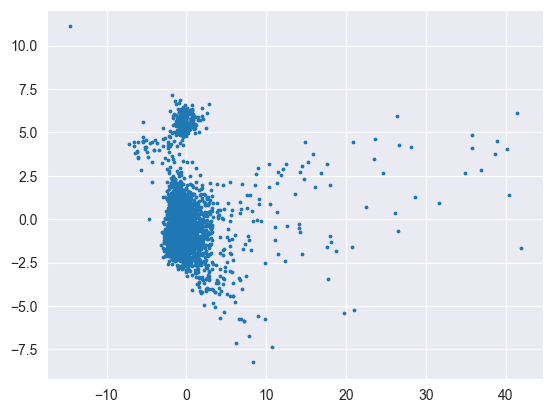

In [337]:
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
plt.scatter(comp[:, 0], comp[:, 1], s=3)

### Non-movement epochs

What we are mainly interested in is splitting the sleep, from non-sleep non-movement epochs. So that is what we try to do here.

In [338]:
df_non_mov = df_full[df_full.movement == 0]
df_numeric = df_non_mov.iloc[:, 4:]
df_numeric.head()

,EMG_L Peak-to-Peak Amplitude,EMG_L RMS Amplitude,EMG_L Peak Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,EMG_L_$\delta$,EMG_L_$\theta$,EMG_L_$\alpha$,EMG_L_$\beta$,...,EMG_R RMS Amplitude,EMG_R Peak Amplitude,EMG_R Zero Crossing Rate,EMG_R Envelope Amplitude,EMG_R Envelope AUC,EMG_R_$\delta$,EMG_R_$\theta$,EMG_R_$\alpha$,EMG_R_$\beta$,EMG_R_$\gamma$
71,0.000781,0.000073,0.000521,0.123917,0.000091,0.492476,-15.122361,-16.251809,-16.274883,-17.341573,...,0.000069,0.000485,0.112115,0.000085,0.462528,-15.229335,-16.532472,-16.095687,-17.769207,-18.400488
72,0.000740,0.000074,0.000434,0.132768,0.000089,0.483936,-14.744674,-15.736566,-16.936179,-17.808171,...,0.000066,0.000338,0.117094,0.000082,0.446587,-14.620380,-15.790112,-16.971779,-17.945769,-18.587934
73,0.000456,0.000062,0.000300,0.069519,0.000080,0.432900,-15.390192,-14.724281,-17.286025,-18.307349,...,0.000061,0.000274,0.072838,0.000078,0.424927,-15.430927,-14.733272,-17.527609,-18.336216,-19.097416
94,0.000547,0.000066,0.000303,0.110824,0.000082,0.442893,-15.135362,-15.189345,-16.906953,-17.376492,...,0.000061,0.000334,0.124470,0.000075,0.406434,-15.518001,-15.212136,-17.106961,-17.685696,-18.490696
231,0.000493,0.000069,0.000278,0.135349,0.000086,0.468422,-15.238749,-15.472548,-16.456291,-17.888566,...,0.000066,0.000221,0.114512,0.000082,0.443869,-15.305074,-15.457839,-16.634861,-18.140183,-18.701775


#### PCA on non-movement epochs

We have generated a huge features dataframe a bit earlier in this notebook. Let's first try PCA on all numerical features.

In [339]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

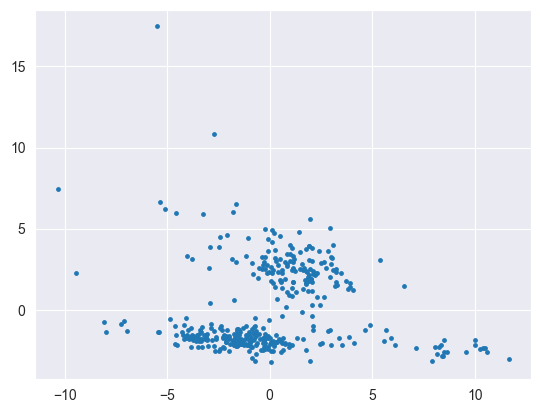

In [340]:
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
plt.scatter(comp[:, 0], comp[:, 1], s=6)

Now we report the explained variance by the two components

In [341]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

for i, ratio in enumerate(explained_variance_ratio):
    print(f"Explained variance ratio of component {i+1}: {ratio:.2%}")

print("\nCumulative explained variance ratio:")
for i, cumulative_ratio in enumerate(cumulative_explained_variance_ratio):
    print(f"First {i+1} components: {cumulative_ratio:.2%}")

Explained variance ratio of component 1: 47.25%
Explained variance ratio of component 2: 30.94%

Cumulative explained variance ratio:
First 1 components: 47.25%
First 2 components: 78.19%


#### Non-movement epochs clustering

We have generated a huge features dataframe a bit earlier in this notebook. Let's first try to cluster on all numerical features

In [350]:
kmeans = KMeans(random_state=40, n_clusters=2)
kmeans.fit(scaled_features)
np.unique(kmeans.labels_, return_counts=True)[1]

array([211, 178], dtype=int64)

In [351]:
df_plot = pd.concat([df_non_mov.reset_index(drop=True), pd.DataFrame(comp)], axis=1)  # add PCA components 1 and 2 to df
df_plot["cluster"] = kmeans.labels_  # add cluster labels
df_plot.head()

,subject_id,epoch_n,movement,frame_start_end,EMG_L Peak-to-Peak Amplitude,EMG_L RMS Amplitude,EMG_L Peak Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,...,EMG_R Envelope Amplitude,EMG_R Envelope AUC,EMG_R_$\delta$,EMG_R_$\theta$,EMG_R_$\alpha$,EMG_R_$\beta$,EMG_R_$\gamma$,0,1,cluster
0,39508,71,0,14087.913060733741-14237.765125103952,0.000781,0.000073,0.000521,0.123917,0.000091,0.492476,...,0.000085,0.462528,-15.229335,-16.532472,-16.095687,-17.769207,-18.400488,0.520895,4.550873,1
1,39508,72,0,14237.765125103952-14387.61718947416,0.000740,0.000074,0.000434,0.132768,0.000089,0.483936,...,0.000082,0.446587,-14.620380,-15.790112,-16.971779,-17.945769,-18.587934,1.200387,3.111182,1
2,39508,73,0,14387.61718947416-14537.46925384437,0.000456,0.000062,0.000300,0.069519,0.000080,0.432900,...,0.000078,0.424927,-15.430927,-14.733272,-17.527609,-18.336216,-19.097416,2.441726,0.271441,1
3,39508,94,0,17684.362605618782-17834.21466998899,0.000547,0.000066,0.000303,0.110824,0.000082,0.442893,...,0.000075,0.406434,-15.518001,-15.212136,-17.106961,-17.685696,-18.490696,1.929774,3.036601,1
4,39508,231,0,44058.325934775734-44208.17799914594,0.000493,0.000069,0.000278,0.135349,0.000086,0.468422,...,0.000082,0.443869,-15.305074,-15.457839,-16.634861,-18.140183,-18.701775,1.808907,1.859282,1


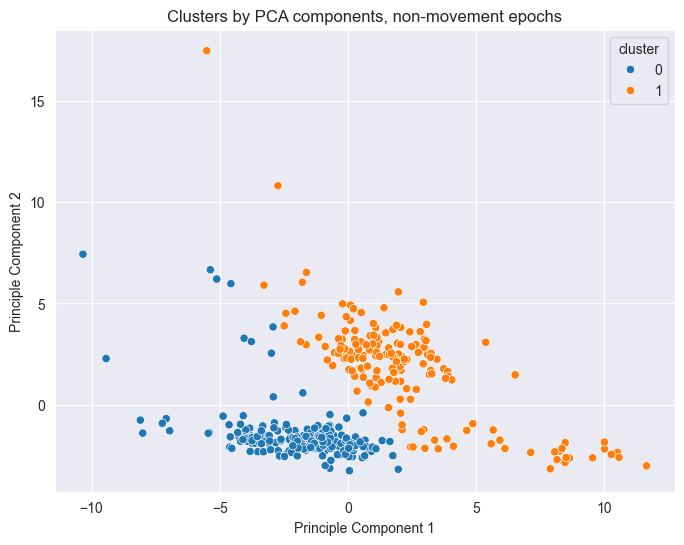

In [352]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="cluster")
plt.title("Clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

What if we try 3 clusters instead of 2? It could be that there are multiple types of sleep/rest in here.

In [353]:
kmeans = KMeans(random_state=40, n_clusters=3)
kmeans.fit(scaled_features)
np.unique(kmeans.labels_, return_counts=True)[1]

array([ 26, 202, 161], dtype=int64)

In [354]:
df_plot = pd.concat([df_non_mov.reset_index(drop=True), pd.DataFrame(comp)], axis=1)  # add PCA components 1 and 2 to df
df_plot["cluster"] = kmeans.labels_  # add cluster labels
df_plot.head()

,subject_id,epoch_n,movement,frame_start_end,EMG_L Peak-to-Peak Amplitude,EMG_L RMS Amplitude,EMG_L Peak Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,...,EMG_R Envelope Amplitude,EMG_R Envelope AUC,EMG_R_$\delta$,EMG_R_$\theta$,EMG_R_$\alpha$,EMG_R_$\beta$,EMG_R_$\gamma$,0,1,cluster
0,39508,71,0,14087.913060733741-14237.765125103952,0.000781,0.000073,0.000521,0.123917,0.000091,0.492476,...,0.000085,0.462528,-15.229335,-16.532472,-16.095687,-17.769207,-18.400488,0.520895,4.550873,0
1,39508,72,0,14237.765125103952-14387.61718947416,0.000740,0.000074,0.000434,0.132768,0.000089,0.483936,...,0.000082,0.446587,-14.620380,-15.790112,-16.971779,-17.945769,-18.587934,1.200387,3.111182,2
2,39508,73,0,14387.61718947416-14537.46925384437,0.000456,0.000062,0.000300,0.069519,0.000080,0.432900,...,0.000078,0.424927,-15.430927,-14.733272,-17.527609,-18.336216,-19.097416,2.441726,0.271441,2
3,39508,94,0,17684.362605618782-17834.21466998899,0.000547,0.000066,0.000303,0.110824,0.000082,0.442893,...,0.000075,0.406434,-15.518001,-15.212136,-17.106961,-17.685696,-18.490696,1.929774,3.036601,2
4,39508,231,0,44058.325934775734-44208.17799914594,0.000493,0.000069,0.000278,0.135349,0.000086,0.468422,...,0.000082,0.443869,-15.305074,-15.457839,-16.634861,-18.140183,-18.701775,1.808907,1.859282,2


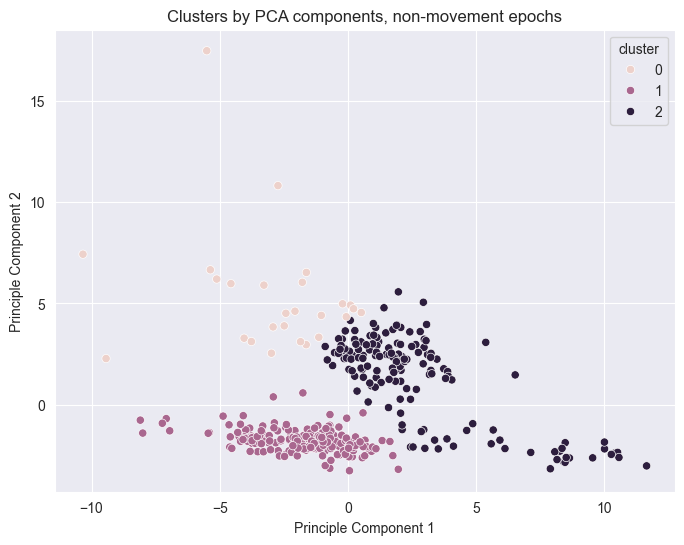

In [355]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="cluster")
plt.title("Clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()